In [1]:
%matplotlib inline


# Understanding the decision tree structure

The decision tree structure can be analysed to gain further insight on the
relation between the features and the target to predict. In this example, we
show how to retrieve:

- the binary tree structure;
- the depth of each node and whether or not it's a leaf;
- the nodes that were reached by a sample using the ``decision_path`` method;
- the leaf that was reached by a sample using the apply method;
- the rules that were used to predict a sample;
- the decision path shared by a group of samples.


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Train tree classifier
First, we fit a :class:`~sklearn.tree.DecisionTreeClassifier` using the
:func:`~sklearn.datasets.load_iris` dataset.



In [3]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

## Tree structure

The decision classifier has an attribute called ``tree_`` which allows access
to low level attributes such as ``node_count``, the total number of nodes,
and ``max_depth``, the maximal depth of the tree. It also stores the
entire binary tree structure, represented as a number of parallel arrays. The
i-th element of each array holds information about the node ``i``. Node 0 is
the tree's root. Some of the arrays only apply to either leaves or split
nodes. In this case the values of the nodes of the other type is arbitrary.
For example, the arrays ``feature`` and ``threshold`` only apply to split
nodes. The values for leaf nodes in these arrays are therefore arbitrary.

Among these arrays, we have:

  - ``children_left[i]``: id of the left child of node ``i`` or -1 if leaf
    node
  - ``children_right[i]``: id of the right child of node ``i`` or -1 if leaf
    node
  - ``feature[i]``: feature used for splitting node ``i``
  - ``threshold[i]``: threshold value at node ``i``
  - ``n_node_samples[i]``: the number of training samples reaching node
    ``i``
  - ``impurity[i]``: the impurity at node ``i``

Using the arrays, we can traverse the tree structure to compute various
properties. Below, we will compute the depth of each node and whether or not
it is a leaf.



In [4]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 is a leaf node.
		node=4 is a leaf node.


We can compare the above output to the plot of the decision tree.



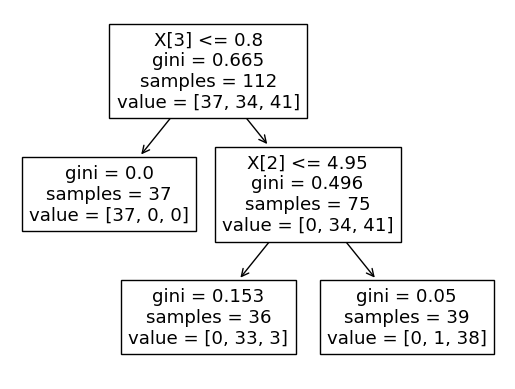

In [5]:
tree.plot_tree(clf)
plt.show()

## Decision path

We can also retrieve the decision path of samples of interest. The
``decision_path`` method outputs an indicator matrix that allows us to
retrieve the nodes the samples of interest traverse through. A non zero
element in the indicator matrix at position ``(i, j)`` indicates that
the sample ``i`` goes through the node ``j``. Or, for one sample ``i``, the
positions of the non zero elements in row ``i`` of the indicator matrix
designate the ids of the nodes that sample goes through.

The leaf ids reached by samples of interest can be obtained with the
``apply`` method. This returns an array of the node ids of the leaves
reached by each sample of interest. Using the leaf ids and the
``decision_path`` we can obtain the splitting conditions that were used to
predict a sample or a group of samples. First, let's do it for one sample.
Note that ``node_index`` is a sparse matrix.



In [6]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 3] = 2.4) > 0.800000011920929)
decision node 2 : (X_test[0, 2] = 5.1) > 4.950000047683716)


For a group of samples, we can determine the common nodes the samples go
through.



In [7]:
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print(
    "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
        samples=sample_ids, nodes=common_node_id
    )
)
print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / n_nodes))


The following samples [0, 1] share the node(s) [0 2] in the tree.
This is 40.0% of all nodes.
